In [20]:
from random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

seed(12345)
np.random.seed(12345)
sns.set_theme()

In [21]:
#Utils para medicion de tiempos
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os
# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 1

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = max(1, (os.cpu_count() or 0) // 4)

def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result


    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [22]:
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, value, PULP_CBC_CMD
from collections import deque
from utils import *

MAIN = '__main__'

def clusterizar_bajo_diametro_pl(grafo, cant_clusters):
    vertices = grafo.obtener_vertices()
    distancias = calcular_distancias(grafo)
    indices_seteo_inicial = hallar_seteo_inicial(vertices, cant_clusters, grafo)
    _, dist_max_aprox = hallar_aproximacion_inicial(vertices, cant_clusters, distancias)

    problema = LpProblem("determinar_clusters", LpMinimize) # Definición del problema

    variables = [] # Fila indica cluster, columna indica vértice
    # Cada variable índica ¿El i-ésimo vértice está en el j-ésimo cluster?:
    for cluster in range(cant_clusters):
        variables.append([LpVariable(f'{v}_{cluster}', cat = "Binary") for v in vertices])

    dist_max = LpVariable(f'dist_max', lowBound = 0, cat = "Continuous") # Máxima distancia
    problema += dist_max <= dist_max_aprox

    # Seteo inicial de vértices que no podrían estar en un mismo clúster:
    for cluster, i in enumerate(indices_seteo_inicial):
        problema += variables[i][cluster] == 1

    for i, v in enumerate(vertices):
        # Cada vértice debe estar en un único cluster:
        problema += lpSum(variables[cluster][i] for cluster in range(cant_clusters)) == 1
        
        for j in range(i + 1, len(vertices)):
            w = vertices[j]

            for cluster in range(cant_clusters):
                # Si los dos vértices pertenecen al mismo clúster, dist_max deberá ser >= a la distancia entre ellos
                problema += distancias[v][w] - distancias[v][w] * (2 - variables[cluster][i] - variables[cluster][j]) <= dist_max
                
    problema += dist_max # Función objetivo (se desea minimizar la distancia máxima)
    problema.solve(PULP_CBC_CMD(msg = False))
    
    # Interpretación de los resultados:
    clusters = []
    for cluster in range(cant_clusters):
        clusters.append([vertices[i] for i in range(len(vertices)) if value(variables[cluster][i]) == 1])
    return clusters, int(value(dist_max))

def hallar_seteo_inicial(vertices, k, grafo):
    seteados_inicialmente = []
    visitados = set()
    for i, v in enumerate(vertices):
        if v not in visitados:
            seteados_inicialmente.append(i)
            if len(seteados_inicialmente) == k:
                break

            visitados.add(v)
            cola = deque([v])
            while cola:
                w = cola.popleft()
                for a in grafo.adyacentes(w):
                    if a not in visitados:
                        visitados.add(a)
                        cola.append(a)
                    
    return seteados_inicialmente

In [23]:
from utils import *

def clusterizar_bajo_diametro(grafo, k):
    vertices = sorted(grafo.obtener_vertices(), key=lambda v: grafo.grado(v)) #ordena por grado ascendente
    distancias = calcular_distancias(grafo)

    sol_opt, diam_max_opt = hallar_aproximacion_inicial(vertices, k, distancias)
    if diam_max_opt == 0 or (diam_max_opt == 1 and k < len(vertices)): # Casos en los que la aproximación es siempre correcta.
        return sol_opt, diam_max_opt

    sol_par, seteados_inicialmente = hallar_clusters_iniciales(vertices, k, grafo)

    return clusterizar_bajo_diametro_bt(1, vertices, k, distancias, sol_par, seteados_inicialmente, 0, sol_opt, diam_max_opt)
    
def clusterizar_bajo_diametro_bt(act, vertices, k, distancias, sol_par, seteados_inicialmente, diam_max_par, sol_opt, diam_max_opt):
    if act == len(vertices):
        return [cluster[:] for cluster in sol_par], diam_max_par
    
    if vertices[act] in seteados_inicialmente:
        return clusterizar_bajo_diametro_bt(act + 1, vertices, k, distancias, sol_par, seteados_inicialmente, diam_max_par, sol_opt, diam_max_opt)
    
    for i in range(k):
        nuevo_diam = calcular_nuevo_diam(vertices[act], sol_par[i], distancias)

        if nuevo_diam >= diam_max_opt: #antes de agregar el nuevo vértice chequea si empeoraría el diámetro máximo del cluster i, en ese caso evita probarlo
            continue

        sol_par[i].append(vertices[act])
        sol_opt, diam_max_opt = clusterizar_bajo_diametro_bt(act + 1, vertices, k, distancias, sol_par, seteados_inicialmente, max(diam_max_par, nuevo_diam), sol_opt, diam_max_opt)
        sol_par[i].pop()

        if len(sol_par[i]) == 0:
            break
    
    return sol_opt, diam_max_opt

def hallar_clusters_iniciales(vertices, k, grafo):
    seteados_inicialmente = set()
    clusters = [[] for _ in range(k)]
    ult = 0
    visitados = set()
    for v in vertices:
        if v not in visitados:
            seteados_inicialmente.add(v)
            clusters[ult].append(v)
            ult += 1
            if ult == k:
                break

            visitados.add(v)
            cola = deque([v])
            while cola:
                w = cola.popleft()
                for a in grafo.adyacentes(w):
                    if a not in visitados:
                        visitados.add(a)
                        cola.append(a)
    return clusters, seteados_inicialmente

def distancia_maxima_por_vertice(vertices, distancias):
    dist_maximas = {}
    for v in vertices:
        dist_maximas[v] = max(distancias[v].values())
    return dist_maximas

def hallar_distancia_maxima(distancias):
    max = 0
    for v in distancias:
        for a in distancias:
            max = distancias[v][a] if distancias[v][a] > max else max
    return max

In [24]:
K = 55

def get_args(size):
    archivo = f'./Archivos/tests/{K}_3.txt'
    grafo = procesar_archivo(archivo)
    return grafo, size

In [25]:
#Generador de resultados para las mediciones del algoritmo
#x = np.array([5, 10, 15, 20, 25, 30])
x = np.array([i for i in range(1, 6)] )
results = time_algorithm(clusterizar_bajo_diametro_pl, x, get_args)

In [26]:
#Funciones a usar para las mediciones y aproximaciones dadas por la catedra
f_n = lambda x, c1, c2: c1 * x + c2
f_nlogn = lambda x, c1, c2: c1 * x * np.log(x) + c2 
f_n2 = lambda x, c1, c2: c1 * x**2 + c2
f_n3 = lambda x, c1, c2: c1 * x**3 + c2

c_n, _ = sp.optimize.curve_fit(f_n, x, [results[n] for n in x])
c_nlogn, _ = sp.optimize.curve_fit(f_nlogn, x, [results[n] for n in x])
c_n2, _ = sp.optimize.curve_fit(f_n2, x, [results[n] for n in x])
c_n3, _ = sp.optimize.curve_fit(f_n3, x, [results[n] for n in x])

In [33]:
#Imprime los resultados de las mediciones en el formato dado
for k, v in results.items():
    print(f"Cantidad de clústeres: {k}, tiempo: {v}\n")

Cantidad de clústeres: 1, tiempo: 0.19938898086547852

Cantidad de clústeres: 2, tiempo: 0.8579955101013184

Cantidad de clústeres: 3, tiempo: 3.304258346557617

Cantidad de clústeres: 4, tiempo: 7.388123035430908

Cantidad de clústeres: 5, tiempo: 20.077534198760986



In [28]:
#Imprime la suma de los tiempos promedio
print(f"Suma de los tiempos promedio: ",sum(results.values()))

Suma de los tiempos promedio:  31.82730007171631


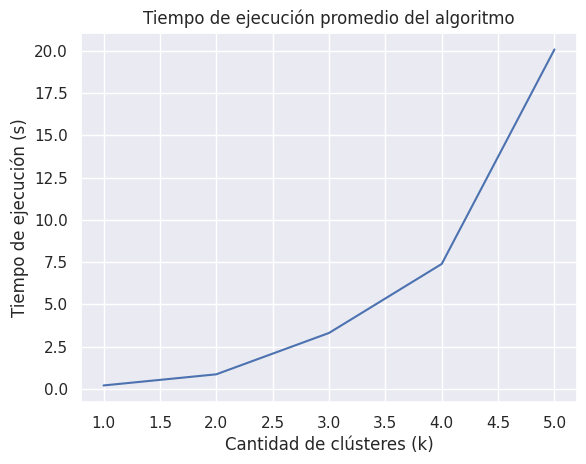

In [35]:

#Crea el grafico del algoritmo por cantidad de elementos en funcion del tiempo (s)
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución promedio del algoritmo')
ax.set_xlabel('Cantidad de clústeres (k)')
ax.set_ylabel('Tiempo de ejecución (s)')
None


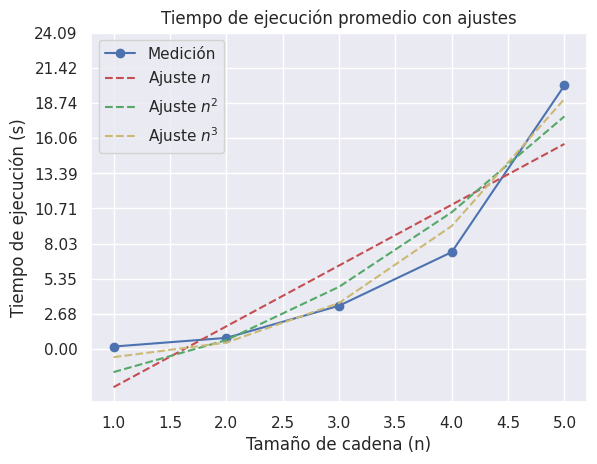

In [30]:
#Crea un grafico como el anterior incluyendo el ajuste a la funcion cuadratica y la lineal logaritmica
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[n] for n in x], "bo-", label="Medición")
ax.plot(x, [f_n(n, c_n[0], c_n[1]) for n in x], 'r--', label="Ajuste $n$")
#ax.plot(x, [f_nlogn(n, c_nlogn[0], c_nlogn[1]) for n in x], 'r--', label="Ajuste $n log(n)$")
ax.plot(x, [f_n2(n, c_n2[0], c_n2[1]) for n in x], 'g--', label="Ajuste $n^2$")
ax.plot(x, [f_n3(n, c_n3[0], c_n3[1]) for n in x], "y--", label="Ajuste $n^3$")
ax.set_yticks(np.linspace(0, max(results.values()) * 1.2, 10))
ax.set_title('Tiempo de ejecución promedio con ajustes')
ax.set_xlabel('Tamaño de cadena (n)')
ax.set_ylabel('Tiempo de ejecución (s)')
ax.legend()
None

Error cuadrático total para n^3: 5.84421589675152


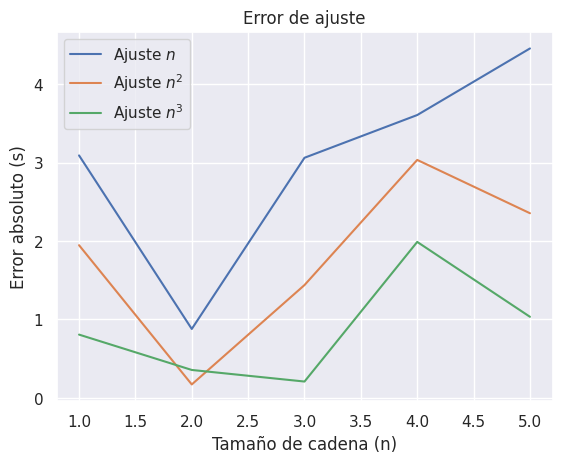

In [31]:
#Crea un grafico que muestra el error de ajuste que hay con la cuadratica y la lineal logaritmica
errors_n2 = [np.abs(c_n2[0] * n**2 + c_n2[1] - results[n]) for n in x]
#errors_nlogn = [np.abs(c_nlogn[0] * n * np.log(n) + c_nlogn[1] - results[n]) for n in x]
errors_n3 = [np.abs(c_n3[0] * n**3 + c_n3[1] - results[n] ) for n in x]
errors_n = [np.abs(c_n[0] * n + c_n[1] - results[n]) for n in x]
print(f"Error cuadrático total para n^3: {np.sum(np.power(errors_n3, 2))}")

ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, errors_n, label="Ajuste $n$")
ax.plot(x, errors_n2, label="Ajuste $n^2$")
#ax.plot(x, errors_nlogn, label="Ajuste $n \log(n)$")
ax.plot(x, errors_n3, label="Ajuste $n^3$")
ax.set_title('Error de ajuste')
ax.set_xlabel('Tamaño de cadena (n)')
ax.set_ylabel('Error absoluto (s)')
ax.legend()
None

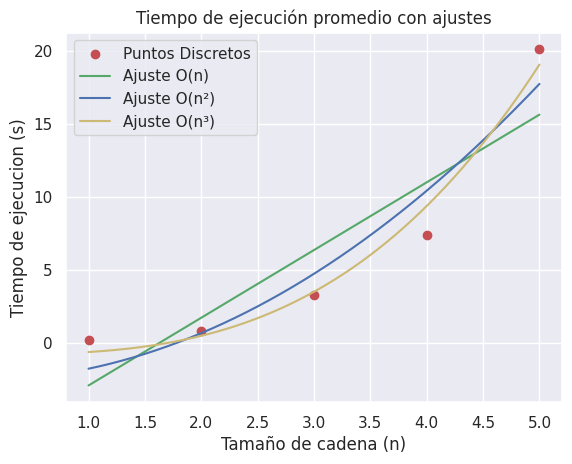

In [32]:
#Crea un grafico de la medicion con puntos discretos parecido al visto anteriormente

x_fit = np.linspace(min(x), max(x), 1000)
y_n = f_n(x_fit, *c_n)
y_n2 = f_n2(x_fit, *c_n2)
y_n3 = f_n3(x_fit, *c_n3)

plt.figure()
plt.scatter(x, [results[n] for n in x], color='r', label='Puntos Discretos', marker='o')
plt.plot(x_fit, y_n, color='g', label='Ajuste O(n)')
plt.plot(x_fit, y_n2, color='b', label='Ajuste O(n²)')
plt.plot(x_fit, y_n3, color='y', label='Ajuste O(n³)')

plt.title('Tiempo de ejecución promedio con ajustes')
plt.xlabel('Tamaño de cadena (n)')
plt.ylabel('Tiempo de ejecucion (s)')
plt.legend()
plt.grid(True)
plt.show()